In [1]:
# start with importing the libraries we need
%matplotlib inline
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt

# Define the parameter
LIF.V_REST = 15*b2.mV
LIF.V_RESET = -50*b2.mV
LIF.FIRING_THRESHOLD = 0*b2.mV
LIF.MEMBRANE_RESISTANCE = 50. * b2.ohm
LIF.MEMBRANE_TIME_SCALE = 10. * b2.ms
ABSOLUTE_REFRACTORY_PERIOD = 0 * b2.ms ####### not sure we have to change this parameter (initially 2.0 * b2.ms) 
beta = 10e5 #s^-1 -> have to precise the factor beta for the instantaneous firing rate

LIF.print_default_parameters()

# Create oscillating external current
Tf = 100 #ms
unit_time = 1*b2.ms
I0 = 0.5*b2.mA
omega = 100*b2.Hz
freq = omega/(2*np.pi)
f_LIF = input_factory.get_sinusoidal_current(0, Tf, unit_time=unit_time, amplitude=I0, frequency=freq, direct_current=I0, append_zero=True)

f_LIF = f_LIF.values[:, 0] / b2.mA
plt.plot(np.linspace(0, Tf+1, Tf+2), f_LIF)
plt.xlabel('Time (ms)')
plt.ylabel('Current (mA)')
plt.show()

1. Consider N = 100 non-interacting neurons, with initial voltages $v_i(t = 0)$ uniformly distributed at random between $v_0$ and $η$ (i.e. $v_i(0) ∼ U([v_0,η])$), and submitted to an oscillating external input $I_{ext}(t) = I_0(1 + sin(ωt))$, with $I_0 = 0.5 mA$, $ω = 10^2 s^{−1}(= 0.1 ms^{−1})$. <br>
• Compute the membrane potentials $v_i(t)$ and firing times of the neurons, for $t ≤ T_f = 100 ms$. <br>
• Plot the voltage $v_i(t)$ of the first neuron, along with the external input $RI_{ext}(t)$.

In [14]:
def oscillating_current(Tf = 100, unit_time = 1*b2.ms, I0 = 0.5*b2.mA, omega = 100*b2.Hz):
    current = np.zeros(Tf+2) * b2.amp
    vals = I0 * (1 + np.sin(omega * range(Tf+1) * unit_time))
    current[:Tf+1] = vals
    return b2.TimedArray(current, dt=1. * unit_time)

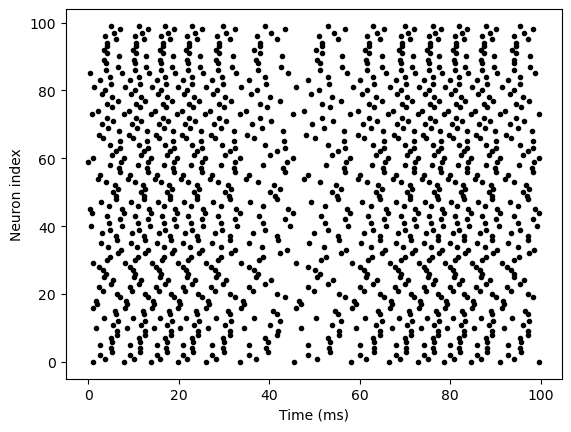

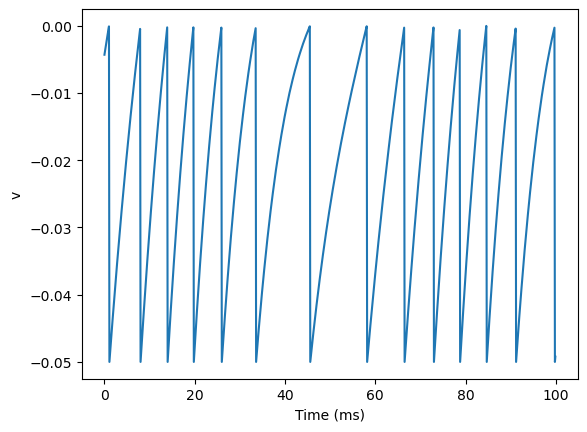

In [15]:
b2.start_scope()

# Define all the parameters
input_current = oscillating_current()
N=100
stimulation_time=100*b2.ms
tau_m=10*b2.ms
v0=-50*b2.mV
eta=0*b2.mV
v_rest=15*b2.mV
R=50*b2.ohm
#beta=10e5*b2.Hz

# Define the differential equation 
eqs = """
dv/dt = ( -(v-v_rest) + R * input_current(t) ) / tau_m : volt
""" # add (unless refractory)

# Create the neuron group
neurons = b2.NeuronGroup(N, model=eqs, threshold='v>eta', reset='v=v0', method='linear') #or method='euler' 'exact

# Initialize the membrane potential at t=0 (uniformly distributed between v0 and eta)
neurons.v = 'rand()*(eta-v0)+v0'

# Monitor the membrane potential and firing times of neurons
potentials = b2.StateMonitor(neurons, 'v', record=0)
spikes = b2.SpikeMonitor(neurons)

# Run the simulation
b2.run(stimulation_time)

# Plot the results
plt.plot(spikes.t/b2.ms, spikes.i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.show()

plt.plot(potentials.t/b2.ms, np.squeeze(potentials.v))
plt.xlabel('Time (ms)')
plt.ylabel('v')
plt.show()

Why is there some inhomogeneity in the potential and firing rate in the middle of the simulation?